## imports

In [1]:
import os
import re
import numpy as np
import torch
import matplotlib.pyplot as plt
import random

from tqdm import tqdm
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from PIL import Image
from maze_dataset.plotting import MazePlot

# for VAE
import importlib
import encoder
import decoder
importlib.reload(encoder)
importlib.reload(decoder)
from encoder import VAE_Encoder
from decoder import VAE_Decoder

# for Diffuser
import importlib
import encoder
import decoder
import model
importlib.reload(encoder)
importlib.reload(decoder)
importlib.reload(model)
from encoder import VAE_Encoder
from decoder import VAE_Decoder
from model import Diffusion
from ddpm import DDPMSampler
# from classifier_guidance.models import Classifier

device = "cuda" if torch.cuda.is_available() else "cpu"

## file paths

In [2]:
vae_path = "good_vae_16"
diff_path = "best_diffusion_model_20250422_204724"

## data get

In [3]:
os.chdir("../")
print(f"Current working directory: {os.getcwd()}")

Current working directory: /home/d/dhansha/UncertinityAI/diffusion-based-environment-generator


In [4]:
def preprocess_image(image, target_size=32):
    image = np.array(image)
    scale_factor = target_size // image.shape[0] 
    # image = np.kron(image, np.ones((scale_factor, scale_factor, 1))) 
    
    # image = image.astype(np.float32) / 127.5 - 1
    image = image.astype(np.float32)
    image = torch.tensor(image).permute(2, 0, 1)
    image = F.interpolate(image.unsqueeze(0), size=(target_size, target_size), mode='nearest').squeeze(0)  # (3, 32, 32)

    return image

def plot_grid_world(grid):
    """
    Plots the given grid world.
    """
    wall = grid[:,:,0] == 0
    source = grid[:,:,1] == 1
    destination = grid[:,:,2] == 1

    img = np.ones((*wall.shape, 3), dtype=np.float32)  # White background
    img[wall] = np.array([0, 0, 0])  # Walls → Black
    img[source] = np.array([1, 0, 0])  # Source → Red
    img[destination] = np.array([0, 1, 0])  # Destination → Green

    return img

def load_dataset_from_npy(parent_directory="./data", target_size=32, max_samples=5000):
    images = []
    path_lengths = []
    num_nodes_traversed_astar = []
    num_nodes_traversed_bfs = []
    
    mazes_directory = os.path.join(parent_directory, "mazes")
    files = sorted([f for f in os.listdir(mazes_directory) if f.endswith(".npy")])
    
    count = 0
    
    for file in files:
        img = np.load(os.path.join(mazes_directory, file))
        if(img.shape != (10,10,3)):
            continue
        # mask = np.all(img == [0, 0, 255], axis=-1)
        # img[mask] = [255, 255, 255]
        # img = img[:-1, :-1]
        # image = preprocess_image(img, target_size)

        image = plot_grid_world(img)
        mask = np.all(image == [0, 0, 255], axis=-1)
        image[mask] = [255, 255, 255]
        image = preprocess_image(image, target_size)

        pattern = r'maze_(\d+)'
        match = re.search(pattern, file)
        num = 0
        if match:
            num = int(match.group(1))
        else:
            continue
        
        # base_name = os.path.splitext(file)[0]
        # len_filename = base_name + "_len.txt"
        len_filename = f"path_length_{num}" + ".npy"
        len_path = os.path.join(mazes_directory, len_filename)
        astar_traversal_filename = f"a_star_{num}" + ".npy"
        astar_traversal_path = os.path.join(parent_directory, "a_star_l1_results" ,astar_traversal_filename)
        bfs_traversal_filename = f"bfs_{num}" + ".npy"
        bfs_traversal_path = os.path.join(parent_directory, "bfs_results" ,bfs_traversal_filename)
        
        # with open(len_path, "r") as f:
        #     maze_length = int(f.read().strip())
        maze_length = np.load(len_path)
        astar_traversal = np.load(astar_traversal_path)
        bfs_traversal = np.load(bfs_traversal_path)
        
        images.append(image)
        path_lengths.append(int(maze_length))
        num_nodes_traversed_astar.append(int(astar_traversal))
        num_nodes_traversed_bfs.append(int(bfs_traversal))

        count += 1
        if count >= max_samples:
            break  
    
    return images, path_lengths, num_nodes_traversed_astar, num_nodes_traversed_bfs

# , [a / b if b!=0 else a for a, b in zip(path_lengths, num_nodes_traversed_astar)], [a / b if b!=0 else a for a, b in zip(path_lengths, num_nodes_traversed_bfs)]

In [5]:
mazes_data_path = "./data"
images, org_path_lengths, num_nodes_astar, num_nodes_bfs = load_dataset_from_npy(mazes_data_path, target_size=32)

In [6]:
class MazeTensorDataset(Dataset):
    def __init__(self, images, path_lengths, num_nodes_astar, num_nodes_bfs):
        self.images = images
        self.path_lengths = path_lengths
        self.num_nodes_astar = num_nodes_astar
        self.num_nodes_bfs = num_nodes_bfs
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx], self.path_lengths[idx], self.num_nodes_astar[idx], self.num_nodes_bfs[idx]

In [7]:
path_lengths = org_path_lengths

## use the scaled path lengths based on the number of nodes traversed
# path_lengths = [a / b if b!=0 else a for a, b in zip(path_lengths, num_nodes_astar)]
# path_lengths = [a / b if b!=0 else a for a, b in zip(path_lengths, num_nodes_bfs)]

print("Total images:", len(images))
print("Total path_lengths:", len(path_lengths))

total = len(images)
test_size = int(0.2 * total)
all_indices = list(range(total))
random.shuffle(all_indices)

test_indices = all_indices[:test_size]
train_indices = all_indices[test_size:]

train_images = [images[i] for i in train_indices]
train_path_lengths = [path_lengths[i] for i in train_indices]
train_num_nodes_astar = [num_nodes_astar[i] for i in train_indices]
train_num_nodes_bfs = [num_nodes_bfs[i] for i in train_indices]

test_images = [images[i] for i in test_indices]
test_path_lengths = [path_lengths[i] for i in test_indices]
test_num_nodes_astar = [num_nodes_astar[i] for i in test_indices]
test_num_nodes_bfs = [num_nodes_bfs[i] for i in test_indices]

dataset = MazeTensorDataset(train_images, train_path_lengths, train_num_nodes_astar, train_num_nodes_bfs)
test_dataset = MazeTensorDataset(test_images, test_path_lengths, test_num_nodes_astar, test_num_nodes_bfs)

print("Train dataset length:", len(dataset))
print("Test dataset length:", len(test_dataset))

dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

unique_train_paths = set(train_path_lengths)
print("Unique training path lengths:", unique_train_paths)
print("Number of unique training paths:", len(unique_train_paths))

unique_test_paths = set(test_path_lengths)
print("Unique test path lengths:", unique_test_paths)
print("Number of unique test paths:", len(unique_test_paths))

Total images: 5000
Total path_lengths: 5000
Train dataset length: 4000
Test dataset length: 1000
Unique training path lengths: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 31}
Number of unique training paths: 26
Unique test path lengths: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 33}
Number of unique test paths: 24


In [8]:
def generate_maze_from_test(sample_idx=None, num_steps=50):
    diffusion_model.eval()
    scheduler.set_inference_timesteps(num_steps)
    
    if sample_idx is None:
        sample_idx = random.randint(0, len(test_dataset) - 1)
    
    test_img, test_path_length, nodes_astar, nodes_bfs = test_dataset[sample_idx]
    path_tensor = torch.tensor([test_path_length]).float().to(device)
    nodes_astar_tensor = torch.tensor([nodes_astar]).float().to(device)
    combined_features = torch.stack((path_tensor, nodes_astar_tensor), dim=-1)

    context = diffusion_model.condition_multidimensional_embedding(combined_features)
    
    # latent = torch.randn((1, 4, 8, 8), device=device)
    latent = torch.randn((1, 8, 16, 16), device=device)
    
    for t in scheduler.timesteps:
        timestep = torch.tensor([t], device=device)
        with torch.no_grad():
            pred = diffusion_model(latent, context, timestep)
        latent = scheduler.step(t, latent, pred)
    
    with torch.no_grad():
        generated_image = vae_decoder(latent / 0.18215)
    
    return generated_image, test_img, test_path_length

In [9]:
def generate_maze_from_prompt(prompt_value, num_nodes=0, num_steps=1000):
    diffusion_model.eval()
    scheduler.set_inference_timesteps(num_steps)

    path_tensor = torch.tensor([prompt_value]).float().to(device)
    nodes_tensor = torch.tensor([num_nodes]).float().to(device)
    combined_features = torch.stack((path_tensor, nodes_tensor), dim=-1)

    # Get the context embedding
    context = diffusion_model.condition_multidimensional_embedding(combined_features)

    # Sample initial latent and run diffusion
    # latent = torch.randn((1, 4, 8, 8), device=device)
    latent = torch.randn((1, 8, 16, 16), device=device)
    for t in scheduler.timesteps:
        timestep = torch.tensor([t], device=device)
        with torch.no_grad():
            noise_pred = diffusion_model(latent, context, timestep)
        latent = scheduler.step(t, latent, noise_pred)

    # Decode to image
    with torch.no_grad():
        generated_image = vae_decoder(latent / 0.18215)

    return generated_image

In [10]:
os.chdir("./diffuser")
print(f"Current working directory: {os.getcwd()}")

Current working directory: /home/d/dhansha/UncertinityAI/diffusion-based-environment-generator/diffuser


### get trained files

In [11]:
vae_encoder = VAE_Encoder().to(device).eval()
vae_decoder = VAE_Decoder().to(device).eval()

checkpoint = torch.load(f"{vae_path}.pth", map_location=device)
vae_encoder.load_state_dict(checkpoint['encoder_state_dict'])
vae_decoder.load_state_dict(checkpoint['decoder_state_dict'])

<All keys matched successfully>

In [12]:
diffusion_model = Diffusion(input_size=2).to(device)
scheduler = DDPMSampler(generator=torch.Generator(device=device), num_training_steps=1000)

checkpoint = torch.load(f"{diff_path}.pth", map_location=device)

diffusion_model.load_state_dict(checkpoint['diffusion_state_dict'])

<All keys matched successfully>

# VAE TESTS

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.105269976..1.1606659].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.036908843..1.079307].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15330613..1.0963042].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.050247982..1.0980749].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05975321..1.1200855].


torch.Size([1, 8, 16, 16])
torch.Size([1, 8, 16, 16])
torch.Size([1, 8, 16, 16])
torch.Size([1, 8, 16, 16])
torch.Size([1, 8, 16, 16])


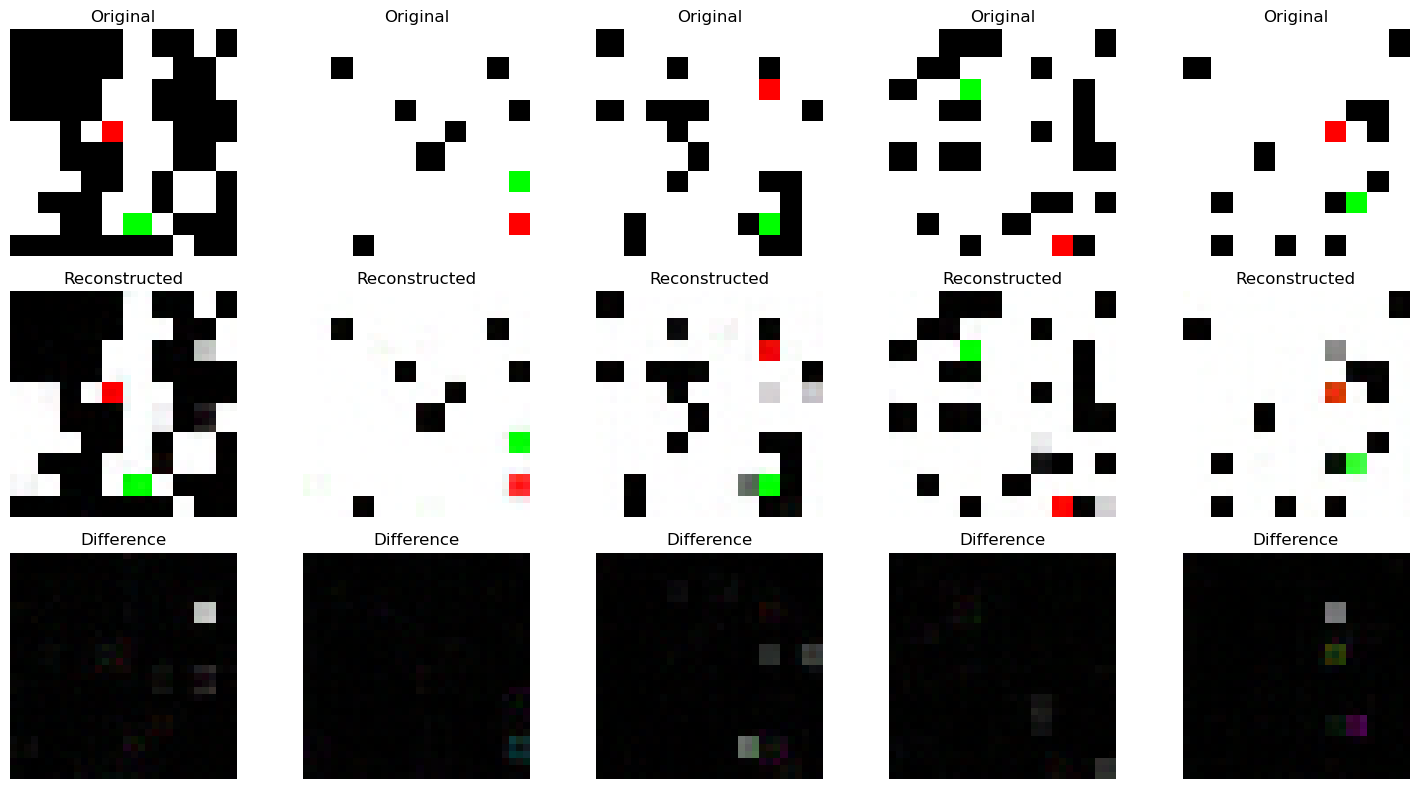

In [13]:
vae_encoder.eval()
vae_decoder.eval()

with torch.no_grad():
    fig, axes = plt.subplots(3, 5, figsize=(15, 8))
    for i in range(5):
        idx = np.random.randint(len(test_dataset))
        img, _, _, _ = test_dataset[idx]  # Ignore the path length label for reconstruction
        img = img.unsqueeze(0).to(device)
        noise = torch.randn(1, 8, 16, 16).to(device)
        # noise = torch.randn(1, LATENT_CHANNELS, 2, 2).to(device)
        # img = torch.tensor(img, dtype=torch.float32).to(device) 
        # img = img.permute(2, 0, 1).unsqueeze(0)
        _, _, z = vae_encoder(img, noise)
        print(z.shape)
        reconstructed = vae_decoder(z).cpu().squeeze(0)
        
        original = img.cpu().squeeze(0)
        
        difference = torch.abs(original - reconstructed)
        
        axes[0, i].imshow(original.permute(1, 2, 0).numpy(), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')
        
        axes[1, i].imshow(reconstructed.permute(1, 2, 0).numpy(), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstructed')
        
        axes[2, i].imshow(difference.permute(1, 2, 0).numpy(), cmap='gray')
        axes[2, i].axis('off')
        axes[2, i].set_title('Difference')
    
    plt.tight_layout()
    plt.show()

# DIFFUSER TESTS

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.43616393..1.0646466].


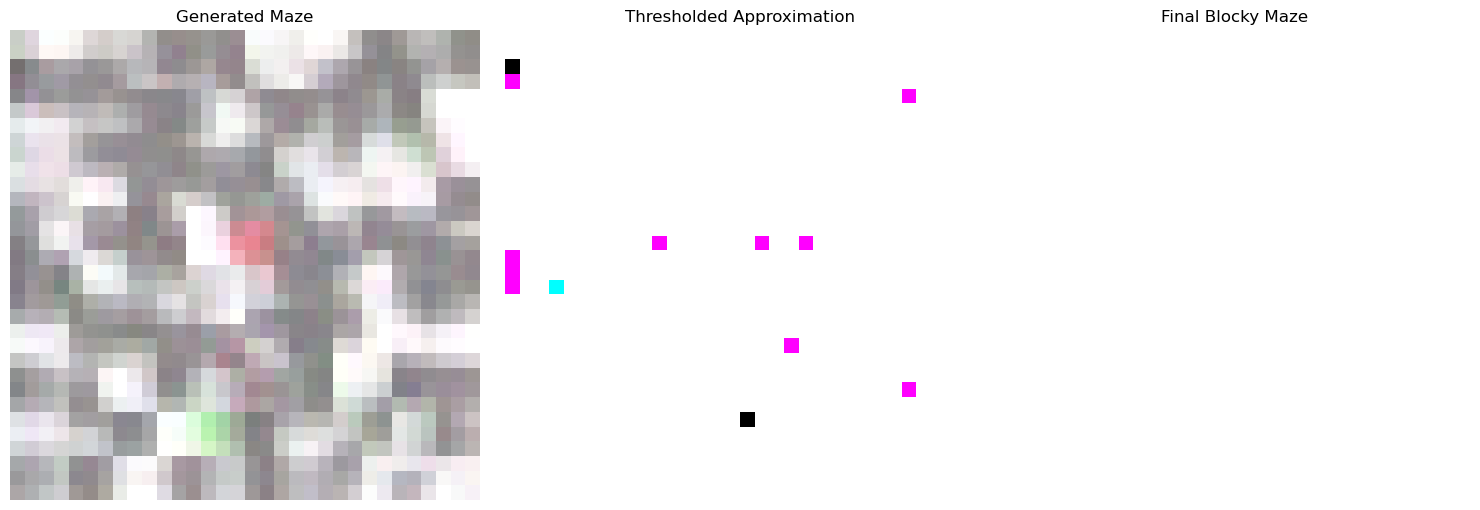

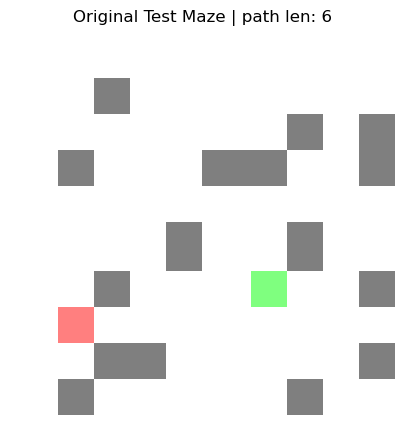

In [14]:
generated, original, test_path_length = generate_maze_from_test(num_steps=1000)

generated_np = generated.squeeze(0).permute(1, 2, 0).cpu().numpy()
generated_np = (generated_np + 1) / 2.0

original_np = original.permute(1, 2, 0).cpu().numpy()
original_np = (original_np + 1) / 2.0

generated_display = generated_np

threshold_value = 0.5
generated_approx = (generated_np > threshold_value).astype(np.float32)

block_size = 4
H, W, C = generated_approx.shape
new_H = H // block_size
new_W = W // block_size

final_blocks = np.zeros((new_H, new_W, C), dtype=np.float32)
for i in range(new_H):
    for j in range(new_W):
        block = generated_approx[i * block_size:(i + 1) * block_size,
                                  j * block_size:(j + 1) * block_size, :]
        final_blocks[i, j, :] = (block.mean(axis=(0, 1)) >= 0.5).astype(np.float32)

final_image = np.repeat(np.repeat(final_blocks, block_size, axis=0), block_size, axis=1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(generated_display)
plt.title("Generated Maze")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(generated_approx)
plt.title("Thresholded Approximation")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(final_image)
plt.title("Final Blocky Maze")
plt.axis("off")

plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(original_np)
plt.title(f"Original Test Maze | path len: {test_path_length}")
plt.axis("off")
plt.show()

In [15]:
prompt_value = 7 
generated = generate_maze_from_prompt(prompt_value=prompt_value)

generated_np = generated.squeeze(0).permute(1, 2, 0).cpu().numpy()
generated_np = (generated_np + 1) / 2.0  # Scale to [0,1]

threshold_value = 0.5
generated_approx = (generated_np > threshold_value).astype(np.float32)

block_size = 4
H, W, C = generated_approx.shape
new_H, new_W = H // block_size, W // block_size
final_blocks = np.zeros((new_H, new_W, C), dtype=np.float32)

for i in range(new_H):
    for j in range(new_W):
        block = generated_approx[i * block_size:(i + 1) * block_size,
                                  j * block_size:(j + 1) * block_size, :]
        final_blocks[i, j, :] = (block.mean(axis=(0, 1)) >= 0.5).astype(np.float32)

final_image = np.repeat(np.repeat(final_blocks, block_size, axis=0), block_size, axis=1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(generated_np)
plt.title("Generated Maze")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(generated_approx)
plt.title("Thresholded Approximation")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(final_image)
plt.title("Final Blocky Maze")
plt.axis("off")

plt.tight_layout()
plt.show()

RuntimeError: Given groups=1, weight of size [320, 8, 3, 3], expected input[1, 4, 8, 8] to have 8 channels, but got 4 channels instead